In [23]:
import tsp_data_util as tsp_data_util
import tsplib95
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import gc
from pso import pso
from aco import aco
from aco_nn import aco_nn
import os
from statistics import mean
from tabu import tabu_search as tabu
import tracemalloc
import pandas as pd

In [2]:
def getData(technique, problem):
    start = time.time()
    tracemalloc.start()
    
    # runs the  problem with the technique
    result = technique(problem.edge_weights)
    end = time.time()
    
    # gets the solution
    returned_solution = result['sequence']
    
    #the time 
    runtime = end-start
    
    # memory
    memory = tracemalloc.get_traced_memory()[1]
    tracemalloc.stop()
    
    
    #function evalauations 
    func_evals = result['func_evals']
    
    #used parameters
    params = result['parameters']

    #find proximity to optimal solution
    solution_distance = tsp_data_util.get_tour_length(problem.file, returned_solution)
    approximation_ratio = solution_distance/problem.solution_length

    return {'memory' : memory, 'closeness' : approximation_ratio, 'func_evals' : func_evals, 'runtime' : runtime}

In [3]:
def generatePlots(results):
    fig, ax = plt.subplots(nrows=1, ncols=3)

    ax[0].scatter(results['memory'], results['closeness'])
    ax[0].set_title('Memory vs. AR')
    ax[0].set_ylabel('Approximation Ratio')
    ax[0].set_xlabel('Memory')
    
    ax[1].scatter(results['func_evals'], results['closeness'])
    ax[1].set_title('Distance Checks vs. AR')
    ax[1].set_ylabel('Approximation Ratio')
    ax[1].set_xlabel('Distance Checks')
    
    ax[2].scatter(results['runtime'], results['closeness'])
    ax[2].set_title('Runtime vs. AR')
    ax[2].set_ylabel('Approximation Ratio')
    ax[2].set_xlabel('Runtime')

    fig.suptitle(results['technique'])
    fig.tight_layout()

heidelberg_TSP_data/gr96.tsp
Problem Success: Ant Colonoy with Neural Network on heidelberg_TSP_data/gr96.tsp, with AR: 1.106504374286801
heidelberg_TSP_data/rd100.tsp
Problem Success: Ant Colonoy with Neural Network on heidelberg_TSP_data/rd100.tsp, with AR: 1.1553729456384323
heidelberg_TSP_data/pcb442.tsp
Problem Success: Ant Colonoy with Neural Network on heidelberg_TSP_data/pcb442.tsp, with AR: 1.334298318169286
heidelberg_TSP_data/p01.tsp
Problem Success: Ant Colonoy with Neural Network on heidelberg_TSP_data/p01.tsp, with AR: 1.0
heidelberg_TSP_data/lin105.tsp
Problem Success: Ant Colonoy with Neural Network on heidelberg_TSP_data/lin105.tsp, with AR: 1.1107170178732875
heidelberg_TSP_data/brg180.tsp
Problem Success: Ant Colonoy with Neural Network on heidelberg_TSP_data/brg180.tsp, with AR: 1.0102564102564102
heidelberg_TSP_data/tsp225.tsp
Problem Success: Ant Colonoy with Neural Network on heidelberg_TSP_data/tsp225.tsp, with AR: 1.2096527068437182
heidelberg_TSP_data/gr666.ts

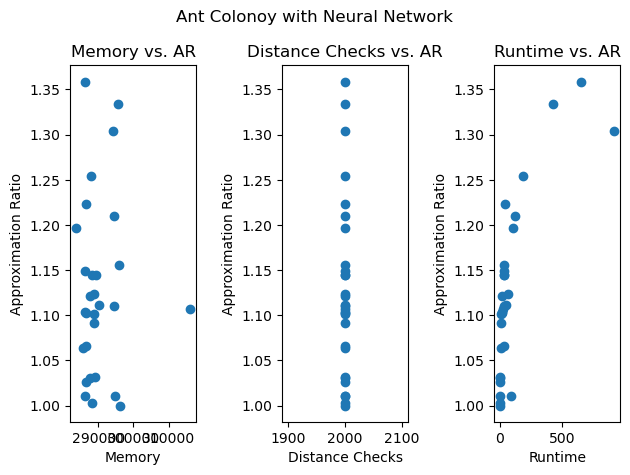

<Figure size 3000x1000 with 0 Axes>

In [15]:
#collect techniques in list
techniques = [T, ACO_NN, ACO, PSO]

#fill problems list
testing_problems = getProbs(problems, 1000)

# run each function on many problems to compare results
for t in techniques:
    figs = []
    # run each problem on the technique
    results = {'memory' : [], 'runtime': [], 'func_evals': [], 'closeness': []}
    for p in testing_problems:
        print(p.file)
        try:
            #take data and add to list for plotting purposes
            r = getData(t.function,p)
            results['memory'].append(r['memory'])
            results['func_evals'].append(r['func_evals'])
            results['runtime'].append(r['runtime'])
            results['closeness'].append(r['closeness'])
            print(f'Problem Success: {t.name} on {p.file}, with AR: {r['closeness']}')
        except:
           print(f'Problem failed: {t.name} on {p.file}')
           """uncomment this line to debug algorithms"""
           #r = getData(t,p)
           

    #for each function, generate a subfigure with each plot
    results['technique'] = t.name
    figs.append(generatePlots(results))
    print(f'Average {t.name} Approximation Ratio: {mean(results['closeness'])}')
    print(f'Average {t.name} Runtime: {mean(results['runtime'])}s')
    print(f'Average {t.name} Memory Allocation: {mean(results['memory'])} bytes')
    print(f'Average {t.name} Function Evaluations: {mean(results['func_evals'])}')
    
fig = plt.figure(figsize=(30, 10))
(figs[0]) = fig.subfigures(3, 1)
title = t.name + 'results.png'
plt.savefig(title)
plt.show()

In [4]:
class Problem:
    
    def __init__(self, edge_weights, solution, solution_length, tspfile):
        self.edge_weights = edge_weights
        self.solution = solution
        self.solution_length = solution_length
        self.file = tspfile

In [9]:
class Technique:
    def __init__(self, function, name):
        self.function = function
        self.name = name
T = Technique(tabu, 'Tabu Search')
ACO = Technique(aco, 'Ant Colony Optimizer')
PSO = Technique(pso, 'Particle Swarm Optimizer')
ACO_NN = Technique(aco_nn, 'Ant Colony with Neural Network')

def fill_problems(directory):
    problems = []
    files = os.listdir(directory)
    for file in files:
        if file.endswith('.tsp'):
            tsp_file = directory + '/' + file
            opt_solution_tour = tsp_data_util.get_optimal_tour(tsp_file)
            if torch.is_tensor(opt_solution_tour):
                weight_matrix = tsp_data_util.generate_edge_weight_matrix(tsp_file)
                opt_solution_length = tsp_data_util.get_tour_length(tsp_file, opt_solution_tour)
                p = Problem(weight_matrix, opt_solution_tour, opt_solution_length, tsp_file)
                problems.append(p)
            else:
                continue
    return problems

problems = fill_problems('heidelberg_TSP_data')

In [14]:
def getProbs(problem_set, MAX_SIZE):
    testing_problems = []
    for p in problem_set:
        if p.solution.size()[0] < MAX_SIZE:
            testing_problems.append(p)
    return testing_problems

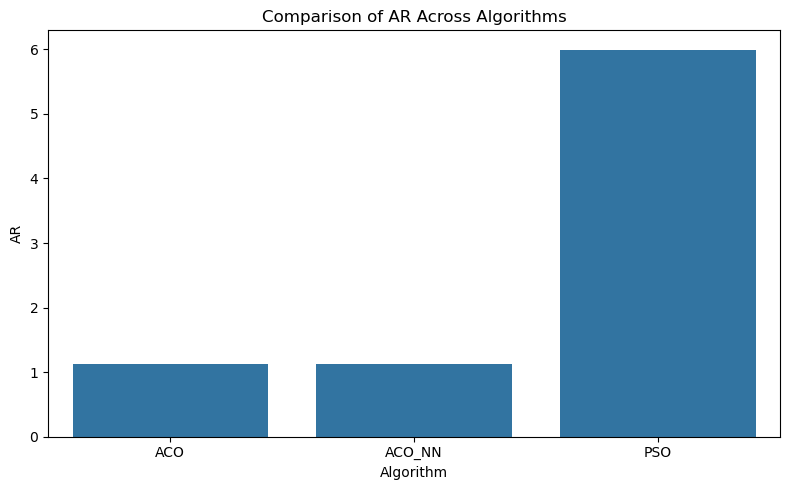

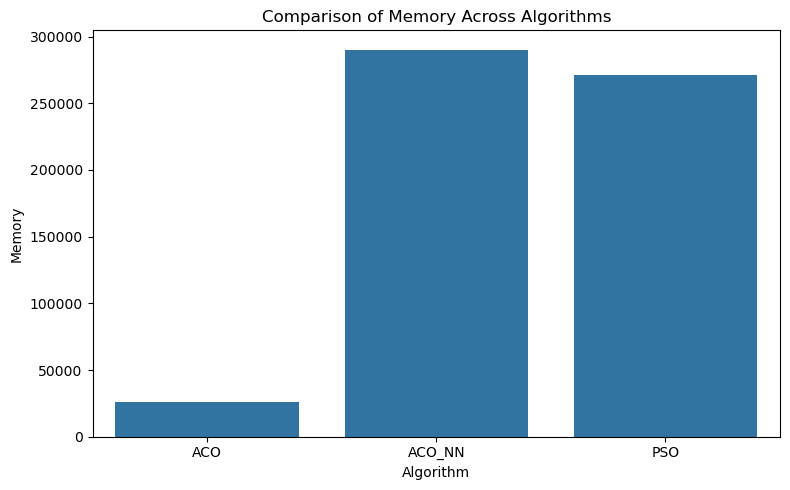

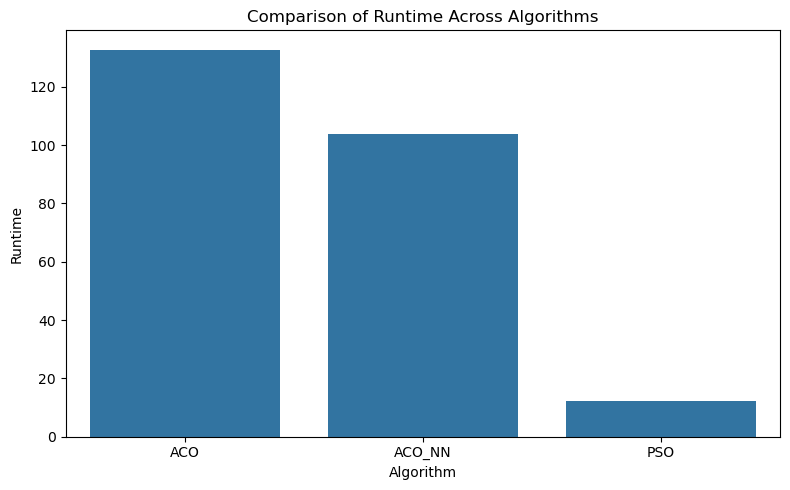

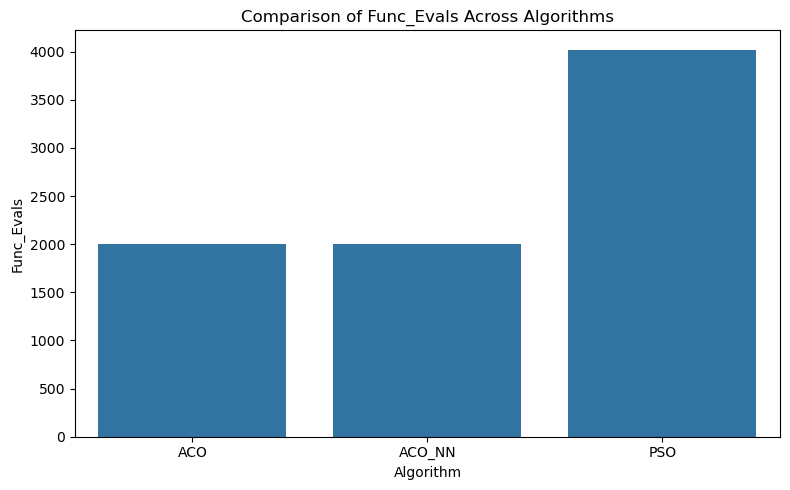

In [33]:
ACO_Stats = {'Algorithm': ['ACO'], 'AR':[1.1292516], 'Memory': [25721], 'Runtime': [132.6755], 'Func_Evals': [2000]}
ACO_NN_Stats = {'Algorithm': ['ACO_NN'],'AR':[1.12716], 'Memory': [290193], 'Runtime': [103.899], 'Func_Evals': [2000]}
PSO_Stats = {'Algorithm': ['PSO'], 'AR':[5.9950], 'Memory': [271454.48], 'Runtime': [12.19], 'Func_Evals': [4020.6896]}
aco_df = pd.DataFrame.from_dict(ACO_Stats)
aco_nn_df = pd.DataFrame.from_dict(ACO_NN_Stats)
pso_df = pd.DataFrame.from_dict(PSO_Stats)

combined_df = pd.concat([aco_df, aco_nn_df, pso_df], ignore_index=True)

metrics = ['AR', 'Memory', 'Runtime', 'Func_Evals']
for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=combined_df, x='Algorithm', y=metric)
    plt.title(f'Comparison of {metric} Across Algorithms')
    plt.ylabel(metric)
    plt.xlabel('Algorithm')
    plt.tight_layout()
    title = metric + 'comparisons.png'
    plt.savefig(title)
    plt.show()